### Loading libraries

In [1]:
%pip install pandas scikit-learn nltk plotly numpy seaborn


Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [3]:
import plotly.express as px


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/grandhi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/grandhi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
# Load data
data = pd.read_csv(
    "./data/nlp-getting-started/train.csv",)

# Encoding target variable
#data["target"] = np.where(data["target"] == "spam", 1, 0)

In [6]:
data.sample(10)

,id,keyword,location,text,target
698,1005,blazing,NaN,I'm blazing rn and there's nothing you can do ...,0
486,704,attacked,1/3 of the blam squad,I'm feeling so attacked https://t.co/CvkQiGr1AZ,0
2976,4273,drowning,"Madison, WI",@NigelTanner1 Believe it or not we've had too ...,1
7496,10723,wreck,United States,AmazonDeals: Skylanders Trap Team: Flip Wreck ...,0
3618,5165,fatalities,"New York City ,NY",Let's fraction the vital need for Our fataliti...,0
7358,10535,windstorm,"Galveston, Texas",For sixth year in a row premium costs for wind...,0
3361,4812,evacuation,NaN,FAAN orders evacuation of abandoned aircraft a...,1
6836,9791,trapped,"St Louis, MO",@BoyInAHorsemask its a panda trapped in a dogs...,1
1464,2112,catastrophe,NaN,#Borrowers concerned at possible #interest rat...,0
3305,4736,evacuate,Sevier County.,So all the store's fire alarms went off today ...,1


In [7]:
df = data.copy()
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
df.sample(10)

,id,keyword,location,text,target
3203,4597,emergency%20plan,"Dallas, TX",@chrisroth98 @chaselabsports in an emergency s...,1
4234,6015,hazardous,NaN,@TheBlackshag @dannyoneil too toxic...cancer.....,1
594,859,bioterror,NaN,FedEx no longer will ship potential bioterror ...,0
794,1152,blight,"Colombo,Sri Lanka.",Releases on the planing level -\n\n1. Constell...,0
5657,8069,rescue,NaN,Suggs &amp; Vivian to the rescue! #psychrewatch,0
2958,4250,drowning,New York,The Drowning Girl by Caitlin R. Kiernan Centip...,0
5510,7863,quarantined,"Livonia, MI",Reddit's new content policy goes into effect m...,0
223,316,annihilated,USA,One thing for sure-God has promised Israel wil...,0
4529,6440,injured,"Piedmont Triad, NC",Unlicensed teen driver among 2 killed in NC cr...,1
3855,5485,flames,@cockerelshoes,New Giant Flames (Giant Manly Brown) info/orde...,0


In [9]:
df['target'] = df['target'].astype('category')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        7613 non-null   int64   
 1   keyword   7552 non-null   object  
 2   location  5080 non-null   object  
 3   text      7613 non-null   object  
 4   target    7613 non-null   category
dtypes: category(1), int64(1), object(3)
memory usage: 245.6+ KB


In [11]:
df.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

In [12]:
df['target'].value_counts()


0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 1.0, 'General tweets and disaster tweets')

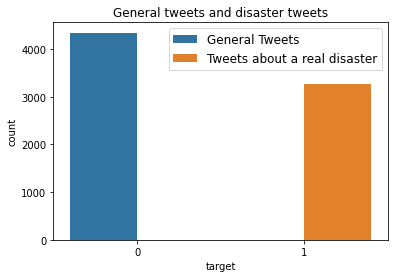

In [13]:
sns.countplot(data=df, x='target', hue='target' )
plt.legend(labels=["General Tweets","Tweets about a real disaster"],
           fontsize = 'large', title_fontsize = "10")
plt.title('General tweets and disaster tweets')

In [14]:
#df1 = df.groupby('keyword').size()
df1 = pd.crosstab(df.keyword,df.target).reset_index()
df1.rename(columns={0:'general',1:'disaster'},inplace=True)
df1.eval('total = general + disaster',inplace=True)
df1.sort_values(by='total',ascending=False,inplace=True)
df1 = df1.head(20)
df1

target,keyword,general,disaster,total
104,fatalities,19,26,45
63,deluge,36,6,42
8,armageddon,37,5,42
177,sinking,33,8,41
57,damage,22,19,41
119,harm,37,4,41
29,body%20bags,40,1,41
153,outbreak,1,39,40
95,evacuate,15,25,40
106,fear,35,5,40


In [15]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Bar(
    x = df1.keyword,
    y=df1.general,
    name= 'General Tweets'
    
   
))
fig.add_trace(go.Bar(
    x = df1.keyword,
    y=df1.disaster,
    name = 'Disaster Tweets' ,
    marker_color='indianred'
))


fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                    title = 'Top 20 keywords used in the Tweets',
                    xaxis_title = 'keywords used in Tweets',
                    yaxis_title = 'counts',legend=dict(
                    yanchor="top",y=0.99,xanchor="left",x=0.80)
                    )
fig.show()


In [16]:
px.bar(df1, y= 'total' , x='keyword')

In [17]:
#filling null values with some number

df['keyword'].fillna('10', inplace=True)
df['location'].fillna('10',inplace=True)

In [18]:
# converting to strings

df['keyword'] = df['keyword'].astype('str')
df['location'] = df['location'].astype('str')


In [19]:
# adding all the columns

df['w1_text'] = df['keyword'] + ' ' + df['text']
df

,id,keyword,location,text,target,w1_text
0,1,10,10,Our Deeds are the Reason of this #earthquake M...,1,10 Our Deeds are the Reason of this #earthquak...
1,4,10,10,Forest fire near La Ronge Sask. Canada,1,10 Forest fire near La Ronge Sask. Canada
2,5,10,10,All residents asked to 'shelter in place' are ...,1,10 All residents asked to 'shelter in place' a...
3,6,10,10,"13,000 people receive #wildfires evacuation or...",1,"10 13,000 people receive #wildfires evacuation..."
4,7,10,10,Just got sent this photo from Ruby #Alaska as ...,1,10 Just got sent this photo from Ruby #Alaska ...
...,...,...,...,...,...,...
7608,10869,10,10,Two giant cranes holding a bridge collapse int...,1,10 Two giant cranes holding a bridge collapse ...
7609,10870,10,10,@aria_ahrary @TheTawniest The out of control w...,1,10 @aria_ahrary @TheTawniest The out of contro...
7610,10871,10,10,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,10 M1.94 [01:04 UTC]?5km S of Volcano Hawaii. ...
7611,10872,10,10,Police investigating after an e-bike collided ...,1,10 Police investigating after an e-bike collid...


In [20]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

In [21]:
### remove special characters

import re
corpus = []
for i in range(len(df['w1_text'])):
    review = re.sub('[^a-zA-Z]', ' ', df['w1_text'][i])
    review = review.lower()
    corpus.append(review)

df['text_fin'] = np.array(corpus)


In [22]:
df.sample(5)

,id,keyword,location,text,target,w1_text,text_fin
417,606,arsonist,Bleak House,Arson suspect linked to 30 fires caught in Nor...,1,arsonist Arson suspect linked to 30 fires caug...,arsonist arson suspect linked to fires caug...
5065,7221,natural%20disaster,"Aurora, IL",I added a video to a @YouTube playlist http://...,0,natural%20disaster I added a video to a @YouTu...,natural disaster i added a video to a youtu...
5779,8246,rioting,SURROUNDED BY WEEABOOS,'Money can't buy happiness' is just a lie we t...,1,rioting 'Money can't buy happiness' is just a ...,rioting money can t buy happiness is just a ...
3415,4888,explode,"Yamaku Academy, Class 3-4",Versions of KS where if a character was /every...,0,explode Versions of KS where if a character wa...,explode versions of ks where if a character wa...
5496,7843,quarantine,10,Reddit Will Now Quarantine OffensiveåÊContent ...,0,quarantine Reddit Will Now Quarantine Offensiv...,quarantine reddit will now quarantine offensiv...


In [23]:
# Tokenization
df['text_token'] = df['text_fin'].apply(nltk.word_tokenize)
df

,id,keyword,location,text,target,w1_text,text_fin,text_token
0,1,10,10,Our Deeds are the Reason of this #earthquake M...,1,10 Our Deeds are the Reason of this #earthquak...,our deeds are the reason of this earthquak...,"[our, deeds, are, the, reason, of, this, earth..."
1,4,10,10,Forest fire near La Ronge Sask. Canada,1,10 Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,10,10,All residents asked to 'shelter in place' are ...,1,10 All residents asked to 'shelter in place' a...,all residents asked to shelter in place a...,"[all, residents, asked, to, shelter, in, place..."
3,6,10,10,"13,000 people receive #wildfires evacuation or...",1,"10 13,000 people receive #wildfires evacuation...",people receive wildfires evacuation...,"[people, receive, wildfires, evacuation, order..."
4,7,10,10,Just got sent this photo from Ruby #Alaska as ...,1,10 Just got sent this photo from Ruby #Alaska ...,just got sent this photo from ruby alaska ...,"[just, got, sent, this, photo, from, ruby, ala..."
...,...,...,...,...,...,...,...,...
7608,10869,10,10,Two giant cranes holding a bridge collapse int...,1,10 Two giant cranes holding a bridge collapse ...,two giant cranes holding a bridge collapse ...,"[two, giant, cranes, holding, a, bridge, colla..."
7609,10870,10,10,@aria_ahrary @TheTawniest The out of control w...,1,10 @aria_ahrary @TheTawniest The out of contro...,aria ahrary thetawniest the out of contro...,"[aria, ahrary, thetawniest, the, out, of, cont..."
7610,10871,10,10,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,10 M1.94 [01:04 UTC]?5km S of Volcano Hawaii. ...,m utc km s of volcano hawaii ...,"[m, utc, km, s, of, volcano, hawaii, http, t, ..."
7611,10872,10,10,Police investigating after an e-bike collided ...,1,10 Police investigating after an e-bike collid...,police investigating after an e bike collid...,"[police, investigating, after, an, e, bike, co..."


In [24]:
# Split dataset between train and test sets
X_train, X_test, y_train, y_test = train_test_split(df["text_fin"], df["target"], random_state=0)

#### Using TF-IDF

In [25]:
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 15
# This means a word should have been used in at least 15 SMS 
vect = TfidfVectorizer( ngram_range=(2,2)).fit(X_train)

# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)

# let's look of some of the words gathered with this method
#sorted(vect.vocabulary_.items(), key=lambda x: x[1])[10:30]

In [26]:
X_train_vectorized.shape

(5709, 58834)

In [27]:
y_train.shape

(5709,)

In [28]:
# how many words appear in more than 15 text messages
len(sorted(vect.vocabulary_.items(), key=lambda x: x[1]))

58834

In [29]:
# save all feature names == words in an array
feature_names = np.array(vect.get_feature_names_out())

#sort for the column names according to highest tfidf value in the column
sorted_tfidf_index = X_train_vectorized.toarray().max(0).argsort()

# print words with highest and lowest tfidf values
print("Smallest tfidf:\n{}\n".format(feature_names[sorted_tfidf_index[:10]]))
print("Largest tfidf: \n{}".format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['cause were' 'homasttopa cause' 'yeah were' 'miss homasttopa' 'fire miss'
 'now yeah' 'fire nowwwwww' 'flaming ducks' 'out flaming' 'do ducks']

Largest tfidf: 
['love skiing' 'screams screams' 'fatality fatality' 'omg earthquake'
 'thunder thunder' 'survive survive' 'love fruits' 'what goooooooaaaaaal'
 'the end' 'meltdown meltdown']


In [30]:
# Train the model
model = LogisticRegression(max_iter=1500)
model.fit(X_train_vectorized, y_train)

# Predict the transformed test documents
predictions = model.predict(vect.transform(X_test))

print("AUC = {:.3f}".format(roc_auc_score(y_test, predictions)))
print("accuracy = {:.3f}".format(accuracy_score(y_test, predictions)))
print("precision = {:.3f}".format(precision_score(y_test, predictions)))
print("recall = {:.3f}".format(recall_score(y_test, predictions)))

AUC = 0.733
accuracy = 0.749
precision = 0.732
recall = 0.634


### Lemmatization

In [31]:
# Initialization
WNlemma = nltk.WordNetLemmatizer()
#analyzer = CountVectorizer().build_analyzer()
analyzer = TfidfVectorizer(min_df=1).build_analyzer()

def lemmatize_word(doc):
    return (WNlemma.lemmatize(t) for t in analyzer(doc))

#lemm_vectorizer = CountVectorizer(analyzer=lemmatize_word)
lemm_vectorizer = TfidfVectorizer(min_df=1, analyzer=lemmatize_word)

# Transform X_train
X_train_lemm_vectorized = lemm_vectorizer.fit_transform(X_train)

In [32]:
# Train the model with stemmed and vectorized dataset
model_lemm = LogisticRegression(max_iter=1500)
model_lemm.fit(X_train_lemm_vectorized, y_train)

# Predict the transformed test documents
predictions1 = model_lemm.predict(lemm_vectorizer.transform(X_test))

print("AUC = {:.3f}".format(roc_auc_score(y_test, predictions1)))
print("accuracy = {:.3f}".format(accuracy_score(y_test, predictions1)))
print("precision = {:.3f}".format(precision_score(y_test, predictions1)))
print("recall = {:.3f}".format(recall_score(y_test, predictions1)))

AUC = 0.799
accuracy = 0.811
precision = 0.806
recall = 0.723


### Stemming

In [33]:
# Initializing stemmer and countvectorizer 
stemmer = nltk.PorterStemmer()
#analyzer = CountVectorizer().build_analyzer()
analyzer = TfidfVectorizer(min_df=1).build_analyzer()


def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# define ContVectorizer with stemming function 
stem_vectorizer = TfidfVectorizer(analyzer=stemmed_words)

# Transform X_train
X_train_stem_vectorized = stem_vectorizer.fit_transform(X_train)

In [34]:
# Train the model with stemmed and vectorized dataset
model_stemm = LogisticRegression(max_iter=1500)
model_stemm.fit(X_train_stem_vectorized, y_train)

# Predict the transformed test documents
predictions = model_stemm.predict(stem_vectorizer.transform(X_test))

print("AUC = {:.3f}".format(roc_auc_score(y_test, predictions)))
print("accuracy = {:.3f}".format(accuracy_score(y_test, predictions)))
print("precision = {:.3f}".format(precision_score(y_test, predictions)))
print("recall = {:.3f}".format(recall_score(y_test, predictions)))

AUC = 0.791
accuracy = 0.804
precision = 0.801
recall = 0.708


### SVM

In [36]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf')
clf.fit(X_train_lemm_vectorized, y_train) 
y_pred_SVC = clf.predict(lemm_vectorizer.transform(X_test))


In [57]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold


Accuracy on test set: 0.811
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1107
           1       0.83      0.69      0.75       797

    accuracy                           0.81      1904
   macro avg       0.82      0.79      0.80      1904
weighted avg       0.81      0.81      0.81      1904

--------------------------------------------------------------------------------


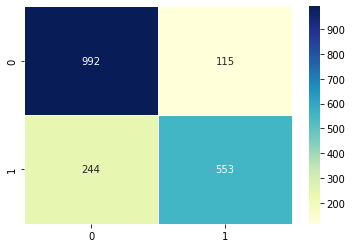

In [38]:
# Print accuracy of our model
#print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_SVC), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_SVC), 3))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_SVC))
print("--------"*10)

# Confusion matrix using confusion_matrix from sklearn
cfm = metrics.confusion_matrix(y_test, y_pred_SVC, )
sns.heatmap(cfm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [39]:
param_grid = [{'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
               'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'auto', 'scale'],
               'C': [0.01, 0.1, 1, 10, 100],
               'degree': [2, 3, 4]
              }]


In [40]:
rs = RandomizedSearchCV(SVC(random_state=42), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=42)

# Fit randomized search object to data
rs.fit(X_train_lemm_vectorized, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=0.1, degree=4, gamma=0.001, kernel=linear;, score=0.736 total time=   2.7s
[CV 2/5] END C=0.1, degree=4, gamma=0.001, kernel=linear;, score=0.736 total time=   2.8s
[CV 3/5] END C=0.1, degree=4, gamma=0.001, kernel=linear;, score=0.729 total time=   2.8s
[CV 4/5] END C=0.1, degree=4, gamma=0.001, kernel=linear;, score=0.728 total time=   2.8s
[CV 5/5] END C=0.1, degree=4, gamma=0.001, kernel=linear;, score=0.731 total time=   2.9s
[CV 1/5] END C=10, degree=4, gamma=scale, kernel=poly;, score=0.692 total time=   3.4s
[CV 2/5] END C=10, degree=4, gamma=scale, kernel=poly;, score=0.687 total time=   3.4s
[CV 3/5] END C=10, degree=4, gamma=scale, kernel=poly;, score=0.698 total time=   3.7s
[CV 1/5] END C=1, degree=2, gamma=0.001, kernel=sigmoid;, score=0.567 total time=   2.7s
[CV 2/5] END C=1, degree=2, gamma=0.001, kernel=sigmoid;, score=0.567 total time=   2.8s
[CV 3/5] END C=1, degree=2, gamma=0.001, kernel=si

RandomizedSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
                   param_distributions=[{'C': [0.01, 0.1, 1, 10, 100],
                                         'degree': [2, 3, 4],
                                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   'auto', 'scale'],
                                         'kernel': ['rbf', 'linear', 'poly',
                                                    'sigmoid']}],
                   random_state=42, scoring='accuracy', verbose=5)

In [41]:
# Best score
print('Best score:', round(rs.best_score_, 3))

# Best parameters
print('Best parameters:', rs.best_params_)

Best score: 0.8
Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 4, 'C': 100}


In [42]:
# Assigning the fitted SGDClassifier model with best parameter combination to a new variable sgd_best
svc_best_rs = rs.best_estimator_

# Making predictions on the test set
y_pred_test_rs = svc_best_rs.predict(lemm_vectorizer.transform(X_test))

Accuracy on test set: 0.82
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1107
           1       0.81      0.73      0.77       797

    accuracy                           0.82      1904
   macro avg       0.82      0.80      0.81      1904
weighted avg       0.82      0.82      0.82      1904

--------------------------------------------------------------------------------


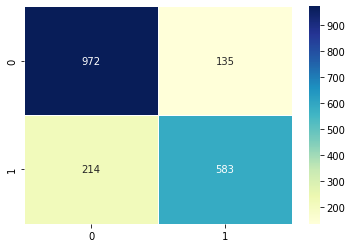

In [43]:
# Print accuracy of our model
#print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_SVC), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test_rs), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_test_rs))
print("--------"*10)

# Confusion matrix using confusion_matrix from sklearn
cfm = metrics.confusion_matrix(y_test, y_pred_test_rs, )
sns.heatmap(cfm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [78]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

parameters = { 'alpha': (1, 2, 0.1, 0.01, 0.001, 0.0001, 0.00001) }  

rs_knn = GridSearchCV(mnb, parameters)

rs_knn.fit(X_train_lemm_vectorized, y_train)

# Best score
print('Best score:', round(rs_knn.best_score_, 3))

# Best parameters
print('Best parameters:', rs_knn.best_params_)

Best score: 0.796
Best parameters: {'alpha': 1}


In [83]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

#List Hyperparameters that we want to tune.
weights = ['uniform', 'distance']

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p, metric : ['minkowski','euclidean','manhattan'])

#Use GridSearch
rs_knn1 = RandomizedSearchCV(knn, hyperparameters, cv=5, verbose=1, n_jobs=-1)

rs_knn1.fit(X_train_lemm_vectorized, y_train)

# Best score
print('Best score:', round(rs_knn1.best_score_, 3))

# Best parameters
print('Best parameters:', rs_knn1.best_params_)

Best score: 0.745
Best parameters: {'p': 2, 'n_neighbors': 9, 'leaf_size': 48}


In [45]:



%pip install xgboost

  Using cached xgboost-1.6.1-py3-none-macosx_12_0_arm64.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [49]:
import xgboost 

#xgboost on lemmatization

xgb = xgboost.XGBClassifier()

xgb.fit(X_train_lemm_vectorized,y_train)

y_pred_xgb = xgb.predict(lemm_vectorizer.transform(X_test))


print("AUC = {:.3f}".format(roc_auc_score(y_test, y_pred_xgb)))
print("accuracy = {:.3f}".format(accuracy_score(y_test, y_pred_xgb)))
print("precision = {:.3f}".format(precision_score(y_test, y_pred_xgb)))
print("recall = {:.3f}".format(recall_score(y_test, y_pred_xgb)))

AUC = 0.764
accuracy = 0.786
precision = 0.813
recall = 0.634


In [50]:
# xgboost on stemming

xgb.fit(X_train_stem_vectorized,y_train)

y_pred_xgb = xgb.predict(stem_vectorizer.transform(X_test))


print("AUC = {:.3f}".format(roc_auc_score(y_test, y_pred_xgb)))
print("accuracy = {:.3f}".format(accuracy_score(y_test, y_pred_xgb)))
print("precision = {:.3f}".format(precision_score(y_test, y_pred_xgb)))
print("recall = {:.3f}".format(recall_score(y_test, y_pred_xgb)))

AUC = 0.761
accuracy = 0.780
precision = 0.791
recall = 0.645


### gridsearch

In [ ]:
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5]
    }
# Set up score
#scoring = ['accuracy']
# Set up the k-fold cross-validation
#kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [52]:
from xgboost import XGBClassifier


gs = GridSearchCV(XGBClassifier(random_state=0), param_grid, scoring='accuracy',cv=5,n_jobs=-1)

gs.fit(X_train_lemm_vectorized, y_train)


[07:57:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "C", "degree", "kernel" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:57:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "C", "degree", "kernel" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:57:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp

/Users/grandhi/Desktop/neuefische/NLPower-capstone-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


600 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/grandhi/Desktop/neuefische/NLPower-capstone-project/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/grandhi/Desktop/neuefische/NLPower-capstone-project/.venv/lib/python3.9/site-packages/xgboost/core.py", line 532, in inner_f
    return f(**kwargs)
  File "/Users/grandhi/Desktop/neuefische/

[08:08:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "C", "degree", "kernel" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [53]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.772
Best parameters: {'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}


In [54]:
gs.best_estimator_

XGBClassifier(C=0.01, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              degree=2, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', kernel='rbf',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [55]:
# Assigning the fitted SGDClassifier model with best parameter combination to a new variable sgd_best
xgb_best_gs = gs.best_estimator_

# Making predictions on the test set
y_pred_test_gs = xgb_best_gs.predict(lemm_vectorizer.transform(X_test))

Accuracy on test set: 0.78
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      1107
           1       0.80      0.63      0.70       797

    accuracy                           0.78      1904
   macro avg       0.79      0.76      0.76      1904
weighted avg       0.78      0.78      0.77      1904

--------------------------------------------------------------------------------


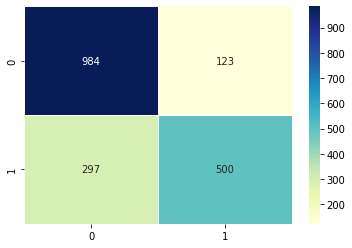

In [56]:
# Print accuracy of our model
#print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_SVC), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test_gs), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_test_gs))
print("--------"*10)

# Confusion matrix using confusion_matrix from sklearn
cfm = metrics.confusion_matrix(y_test, y_pred_test_gs, )
sns.heatmap(cfm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);



In [65]:
#random search

# Define the search space
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
# Set up score
scoring = ['accuracy']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [69]:
# Define random search
rs_xgb = RandomizedSearchCV(XGBClassifier(random_state=0), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=0)
# Fit grid search
rs_xgb.fit(X_train_lemm_vectorized, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.01, max_depth=12, reg_alpha=100, reg_lambda=0.1;, score=0.651 total time=   1.6s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.01, max_depth=12, reg_alpha=100, reg_lambda=0.1;, score=0.662 total time=   1.7s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.01, max_depth=12, reg_alpha=100, reg_lambda=0.1;, score=0.697 total time=   1.7s
[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.01, max_depth=12, reg_alpha=100, reg_lambda=0.1;, score=0.657 total time=   1.7s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.01, max_depth=12, reg_alpha=100, reg_lambda=0.1;, score=0.689 total time=   2.1s
[CV 2/5] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=9, reg_alpha=1e-05, reg_lambda=1;, score=0.754 total time=   2.3s
[CV 1/5] END colsample_bytree=0.6, gamma=0.4, learning_rate=0.1, max_depth=9, reg_a

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           predictor=None, random_state=0,
                                           reg_alpha=None, reg_

In [73]:
rs_xgb.best_estimator_


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, ...)

In [71]:
# Assigning the fitted SGDClassifier model with best parameter combination to a new variable sgd_best
xgb_best_rs = rs_xgb.best_estimator_

# Making predictions on the test set
y_pred_test_rs = xgb_best_rs.predict(lemm_vectorizer.transform(X_test))

Accuracy on test set: 0.78
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1107
           1       0.82      0.60      0.69       797

    accuracy                           0.78      1904
   macro avg       0.79      0.75      0.76      1904
weighted avg       0.78      0.78      0.77      1904

--------------------------------------------------------------------------------


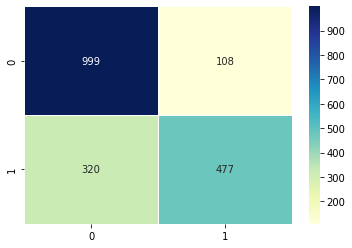

In [72]:
# Print accuracy of our model
#print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_SVC), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test_rs), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred_test_rs))
print("--------"*10)

# Confusion matrix using confusion_matrix from sklearn
cfm = metrics.confusion_matrix(y_test, y_pred_test_rs, )
sns.heatmap(cfm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

